In [95]:
import geopandas as gpd
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import planetary_computer
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [96]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp')
aoi_4326 = aoi.to_crs('EPSG: 4326')
bbox = aoi_4326.total_bounds
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
year = ['2018', '2020', '2021']

In [97]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

In [98]:
s2_search_2018 = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox= bbox,
        datetime= year[2] + '-01-01/' + year[2] + '-12-31',
        query={
                #'eo:cloud_cover': {"lt": 100}, 
                's2:nodata_pixel_percentage': {'lt': 50},
                's2:mgrs_tile': {'eq': '30PVT'}},
        )
item2018 = s2_search_2018.item_collection()

In [99]:
len(item2018)

71

In [115]:
stack = stackstac.stack(item2018, resolution = 10, bounds = aoi.total_bounds, chunksize= (len(item2018), 1, 'auto', 'auto'))

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [116]:
stack

<xarray.DataArray 'stackstac-549955982dd32aee2bf4a76a2ba5265c' (time: 71,
                                                                band: 17,
                                                                y: 4513, x: 5183)>
dask.array<fetch_raster_window, shape=(71, 17, 4513, 5183), dtype=float64, chunksize=(71, 1, 453, 520), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2021-01-04...
    id                                       (time) <U54 'S2B_MSIL2A_20210104...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    platform                                 (time) <U11 'Sentinel-2B' ... 'S...
    ...                                       ...
    gsd                                      (band) object 10.0 60.0 ... None
    proj:bbox                                (band) object [399960.0, 1190220...
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

In [100]:
petite_bbox = [415000, 1240000, 415000+1000, 1240000+1000]
stack2018 = stackstac.stack(item2018, resolution = 10, bounds = petite_bbox, chunksize= (69, 1, 100, 100))
stack2018 = stack2018.drop_duplicates(dim = 'time')
SCL = stack2018.sel(band = 'SCL')
stack2018 = stack2018.sel(band = bands)

cirrus = xr.where(SCL == 10, 1, 0) # cirrus pixels, binary mask 0, 1
highclouds = xr.where(SCL == 9, 1, 0) # High probability clouds, binary mask 0, 1
medclouds = xr.where(SCL == 8, 1, 0) # Medium probability clouds, binary mask 0, 1
unclass = xr.where(SCL == 7, 1, 0) # unclassified pixels, binary mask 0, 1
shaclouds = xr.where(SCL == 3, 1, 0) # Cloud shadows, binary mask 0, 1
saturated = xr.where(SCL == 1, 1, 0) # saturated pixels, binary mask 0, 1

## mannually check quality of final interpolation

mask = highclouds + medclouds + shaclouds + saturated + cirrus + unclass # Mask, binary mask 0, 1
maskedstack = stack2018.where(mask == 0, np.nan)

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [105]:
maskedstack

<xarray.DataArray 'stackstac-089cd6380eda46d00196eef653b36982' (time: 68,
                                                                band: 10,
                                                                y: 100, x: 100)>
dask.array<where, shape=(68, 10, 100, 100), dtype=float64, chunksize=(67, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                     (time) datetime64[ns] 2021-01-04...
    id                                       (time) <U54 'S2B_MSIL2A_20210104...
  * band                                     (band) <U7 'B02' 'B03' ... 'B12'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    platform                                 (time) <U11 'Sentinel-2B' ... 'S...
    ...                                       ...
    proj:epsg                                int64 32630
    s2:datastrip_id                          (time) <U64 'S2B_OPER_MSI_L2A_DS...
    sat:relative_orbit                       int64 108
    s2:granule_id                            (time) <U62 'S2B_OPER_MSI_L2A_TL...
    proj:bbox                                (band) object [399960.0, 1190220...
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [101]:
corr = 5 - maskedstack.time.dt.dayofyear.values[0]

In [102]:
pc_idx = (maskedstack.time.dt.dayofyear.values + corr) / 5
missing_idx = np.setdiff1d(np.arange(5, 370, 5) / 5, pc_idx)
n_missing = missing_idx.shape[0]

pcdata = np.array(maskedstack.values)
n_bands = pcdata.shape[1]
n_y = pcdata.shape[2]
n_x = pcdata.shape[3]
nandata = np.array([np.nan]*n_missing*n_bands*n_y*n_x).reshape(n_missing, n_bands, n_y, n_x)
completets = np.zeros((73, n_bands, n_y, n_x))


In [103]:
pc_idx

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 63., 64., 65., 66., 67., 68., 69., 70.,
       71., 72., 73.])

In [104]:
missing_idx

array([58., 59., 60., 61., 62.])

In [85]:
n_missing

6

In [54]:

for n, i in enumerate(pc_idx):
    completets[int(i)-1, :, :, :] = pcdata[n, :, :, :]

In [55]:
for n, i in enumerate(missing_idx):
    completets[int(i)-1, :, :, :] = nandata[n, :, :, :]

In [56]:
x = maskedstack.indexes['x']
y = maskedstack.indexes['y']
band = maskedstack.indexes['band']
dates2018 = [pd.to_datetime(doy-1, unit='D', origin=str(2018)) for doy in np.arange(5, 370, 5)]
time = pd.Index(dates2018, name = 'time')

In [57]:
temp2018 = xr.DataArray(
    data = completets,
    coords=dict(time = time,
                 band = band,
                 y = y,
                 x = x)
    
    )
temp2018._copy_attrs_from(maskedstack)

In [58]:
interp2018 = temp2018.interpolate_na(dim="time", method="linear", use_coordinate = 'time')
minmax_bandtime = interp2018.quantile([0.02, 0.98], dim=['x', 'y'])
norm2018 = (interp2018 - minmax_bandtime[0, :, :]) / (minmax_bandtime[1, :, :] - minmax_bandtime[0, :, :])
norm2018_2 = norm2018.where(norm2018 > 0, 0, drop=True)
norm2018_2 = norm2018_2.where(norm2018_2 < 1, 1, drop=True)

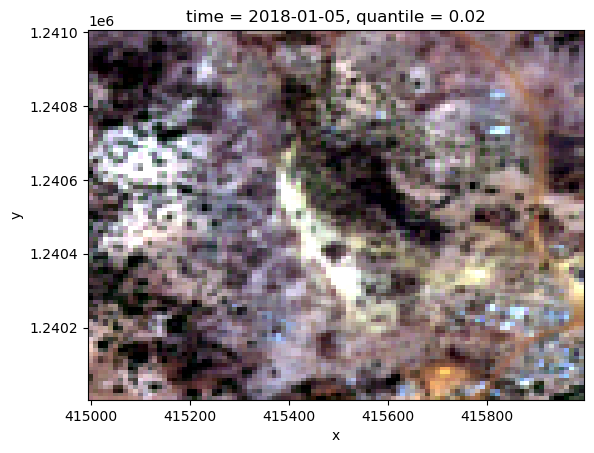

In [59]:
norm2018_2[0,:, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

In [86]:
for t in tqdm(np.arange(0, 73, 1)):
    for b in np.arange(0, 10, 1):
        norm2018_2[t, b, :, :].rio.to_raster("./testimages/s2_{}_{}.tif".format(time[t].strftime('%Y%m%d'), bands[b]))